# Database search with Grover's using Sampler

In this tutorial, you will solve a small database search problem using Grover's algorithm with the Sampler primitive Qiskit Runtime program.

## Before you begin

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, follow the [Getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Background information

### Unstructured search problem

In the olden days, you looked up a person's phone number in a phone book. That is an easy task if you know the person's name because a phone book is ordered alphabetically by name. However, the opposite task, that is, you are given a phone number and want to find out who it belongs to, is much more difficult. That is because a phone book is not ordered by phone numbers. This is an example of an unstructured search problem. To solve this problem with a classical computer, your best trick is to randomly pick an entry. On average, you will need to look up half of the entries ($N/2$, if $N$ is the total number of entries) to find the owner. If you have a quantum computer, however, you can use Grover's algorithm to find the owner in $\sqrt N$ tries. That means to identify the owner in a phone book that has 1 million numbers, you only need to access 1000 entries, rather than 500,000!

### Grover's algorithm

In a nutshell, Grover's algorithm uses a nice quantum trick called amplitude amplification to dramatically increase the chances of finding the correct answer - the owner of a phone number - in each try (iteration). That's all you need to know now. You don't have to understand the details about how Grover's algorithm works to apply it, because Qiskit does it for you! However, if you are interested, you can read the chapter about Grover's algorithm in [the Qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html).

Next, let's look at a concrete example.

## Overview

In this tutorial, you are going to look for the owner of a small phone book using Grover's algorithm following these steps:

1. Create Grover's circuit for the phone book search problem.
2. Submit the circuits to a quantum computer on the cloud using Qiskit Runtime service and the Sampler primitive program.
3. Analyze the results and identify the owner of the phone number.

## Step 1: Create Grover's circuit

### Define an unstructured search problem in Qiskit

In this simple example, you are given a small phone book that has 8 entries, person 0 to person 7, and you want to find the owner of a certain phone number. However, you are not allowed to look at the phone book directly. You are only allowed to consult an 'oracle': a black-box circuit that immediately tells you if your guess is right or wrong (like the Oracle in "The Matrix").

In [1]:
import random
from qiskit.quantum_info import Statevector

secret = random.randint(0, 7)  # the owner is randomly picked
secret_string = format(secret, "03b")  # format the owner in 3-bit string
oracle = Statevector.from_label(secret_string)  # let the oracle know the owner

Once you have the oracle, you can define the unstructured search problem using the `AmplificationProblem` class in Qiskit. 

In [2]:
from qiskit.algorithms import AmplificationProblem

problem = AmplificationProblem(oracle, is_good_state=secret_string)

### Construct Grover's circuit for the problem

Now you are ready to construct the quantum circuits for Grover's algorithm for this problem. Grover's algorithm's accuracy in finding the correct answer increases with the number of iterations. Let's create two circuits with one and two iterations each to see this effect.

In [3]:
from qiskit.algorithms import Grover

grover_circuits = []
for iteration in range(1, 3):
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()
    grover_circuits.append(circuit)

Let's look at the circuits:

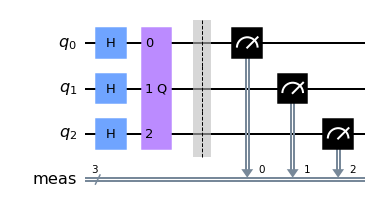

In [4]:
# Grover's circuit with 1 iteration
grover_circuits[0].draw()

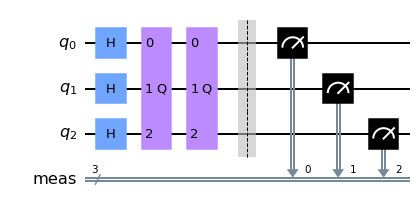

In [5]:
# Grover's circuit with 2 iterations
grover_circuits[1].draw()

## Step 2: Submit the circuits to a quantum computer on the cloud

Now that the Grover's circuits are created, let's submit them to a quantum computer on the cloud by using the Sampler program.

### Connect to the Qiskit Runtime service 

First, connect to the Qiskit Runtime service instance that you created in [the first step](#Set-up-your-local-development-environment).

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"  # use the simulator

Grover's algorithm determines the correct answer based on the highest probability of measurement outcomes. The `Sampler` primitive program is perfect for getting probabilities, so you will use that. In the following cell, you create an instance of the `Sampler` program, and start a Runtime session using the context manager (`with ...:`), which automatically opens and closes the session for you. 

The `Sampler` program allows a batch submission of circuits in a job. Here you are passing a list of two circuits (Grover with 1 iteration and 2 iterations) to the Sampler but only one call is needed to sample the probability of measurement outcomes of both circuits.

In [7]:
from qiskit_ibm_runtime import Sampler, Session

with Session(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(circuits=grover_circuits, shots=1000)
    result = job.result()
    print(result)

SamplerResult(quasi_dists=[{1: 0.029, 2: 0.026, 5: 0.032, 3: 0.808, 0: 0.029, 7: 0.029, 6: 0.023, 4: 0.024}, {5: 0.011, 2: 0.012, 0: 0.007, 3: 0.936, 7: 0.005, 6: 0.015, 4: 0.006, 1: 0.008}], metadata=[{'header_metadata': {}, 'shots': 1000}, {'header_metadata': {}, 'shots': 1000}])


## Step 3: Analyze the results

Let's look at the results:

As you can see, the quantum computer returned `3` as the answer with highest probability.
And the results with 2 iterations have higher probability than the results with 1 iteration.


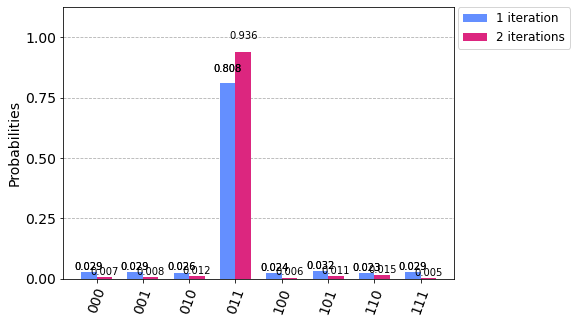

In [8]:
from qiskit.tools.visualization import plot_histogram

# Extract bit string with highest probability from results as the answer
result_dict = result.quasi_dists[1].binary_probabilities()
answer = max(result_dict, key=result_dict.get)
print(
    f"As you can see, the quantum computer returned '{answer}' as the answer with highest probability.\n"
    "And the results with 2 iterations have higher probability than the results with 1 iteration."
)

# Plot the results
plot_histogram(result.quasi_dists, legend=["1 iteration", "2 iterations"])

Let's print out the quantum result, along with the secret string, to check the quantum computer found the correct answer.

In [9]:
# Print the results and the correct answer.
print(f"Quantum answer: {answer}")
print(f"Correct answer: {secret_string}")
print("Success!" if answer == secret_string else "Failure!")

Quantum answer: 011
Correct answer: 011
Success!


Congratulations! You have successfully found the owner of the phone number. 

You can re-run the tutorial a few times to generate other random secret strings to check that we are not cheating! The quantum computer will find the correct answer every time.

## Summary

In this tutorial, you have solved a small database search problem using a quantum computer. You have constructed Grover's circuits by defining a phone book search problem using the `AmplificationProblem` class in Qiskit and then submitted the circuits to run using the Sampler primitive program through Qiskit Runtime service. 

## References

1. Harkins, F., Grover's search algorithm. In A. Abbas, et al. Learn Quantum Computation Using Qiskit. URL: https://learn.qiskit.org/course/introduction/grovers-search-algorithm (accessed 09/01/2022) (2020).

### Qiskit versions and copyright

In [10]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.7.0'

In [11]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright